## Inference Inspect

In [9]:
import numpy as np
import pickle

import engine
import model
import utils
import train

In [10]:
# Load training text to recover vocab and vocab_size, since we don't store them externally
text = train.prepare_input("data/shakespeare.txt")
encoded_data, vocab = train.tokenize_data(text)
vocab_size = len(vocab)

# Load pretrained weights
with open("./out/weights.pkl", "rb") as f:
    params = pickle.load(f)
print("Weights loaded from weights.pkl")
output_text = "ROMEO: "
viz_info = {}

# Initial prompt (context):
if 'output_text' not in locals():
    output_text = "ROMEO: "
    viz_info = {}

Weights loaded from weights.pkl


Context: ROMEO: how, t

Top candidates (softmax):
  'h': 93.63%  <--- Selected
  'o': 3.89% 
  'e': 1.18% 
  'i': 0.77% 
  'r': 0.28% 

Infered character: 'h'

Generated text:
ROMEO: how, th



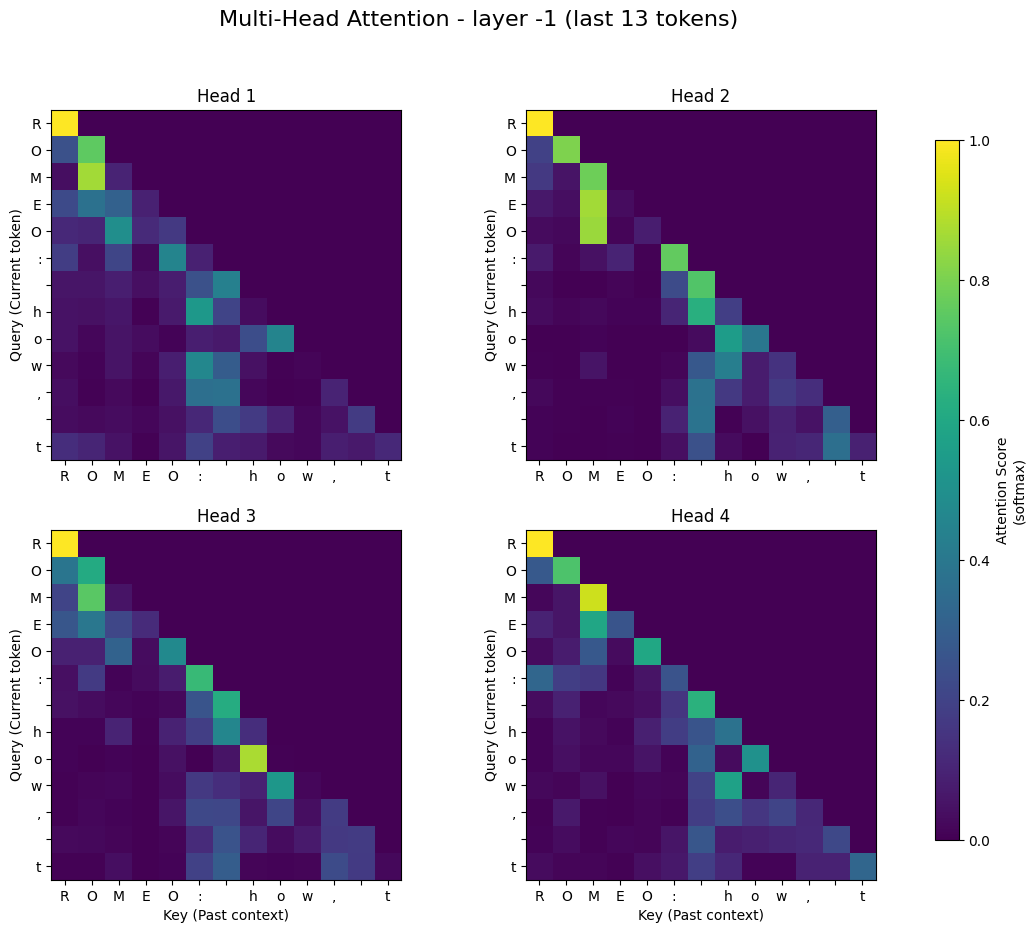

In [17]:
# Step-by-Step Autoregressive Inference

print(f"Context: {output_text}")

# Create a token based on the current context
# We only request ONE token for a step-by-step view (max_new_tokens=1)
gen = model.generate_stream(
    output_text, vocab, params, 
    max_new_tokens=1, 
    temperature=0.8, 
    k=10, 
    out_info=viz_info
)

# Run the inference
new_char = next(gen)
output_text += new_char

if "probs" in viz_info:
    p = viz_info["probs"]
    # Get indices of the top 5 probabilities
    top_5_idx = np.argsort(p)[-5:][::-1]
    
    print("\nTop candidates (softmax):")
    for i in top_5_idx:
        char = utils.decode([i], vocab)
        prob = p[i]
        # Clean up newline display
        display_char = char.replace("\n", "\\n")
        marker = " <--- Selected" if char == new_char else ""
        print(f"  '{display_char}': {prob:.2%} {marker}")

print(f"\nInfered character: '{new_char}'\n")
print(f"Generated text:\n{output_text}\n")

# Multi-head Attention Visualization
utils.plot_multi_head_attention(vocab, viz_info)

## Gradient check

Since our model doesn't use autograd, we need to make sure it's sound before training for hours.
This cell performs a numerical verification of the analytical gradients computed in the backward pass.

We will compare the gradient of W_o_0 (out weights for layer 0) with two independent methods:

  1 - **Analytical Gradient**: that's our backward pass from `backward_attention` in engine.py

  2 - **Numerical Gradient**: that's a mathematical approximation using the [finite difference method](https://en.wikipedia.org/wiki/Finite_difference). This is very slow but mathematically robust.

If the tensor transpositions, reshapes, and the softmax derivative in the Multi-Head Attention are mathematically correct, the difference between the two should be infinitesimal (<1e-7).

In [10]:
def grad_check_Wo(params, layer_idx=0):
    T = 4
    d_model = params["d_model"]
    np.random.seed(42)
    
    # Some random input
    X_test = (np.random.randn(1, T, d_model) * 0.1).astype(np.float64)
    d_att_out = (np.random.randn(T, d_model) * 0.1).astype(np.float64)
    
    # Analytic pass
    att_out, cache = model.multi_head_attention(X_test, params, layer_idx)
    _, _, _, _, dWo_anal = engine.backward_attention(d_att_out, cache)

    # W_o
    eps = 1e-8
    target_key = f"W_o_{layer_idx}"
    target_W = params[target_key]
    num_grad_Wo = np.zeros_like(target_W)

    print(f"Computing gradient for {target_key}...")

    W_flat = target_W.ravel()
    grad_flat = num_grad_Wo.ravel()

    # Numerical pass
    for i in range(len(W_flat)):
        old_val = W_flat[i]

        # f(x + eps)
        W_flat[i] = old_val + eps
        out_p, _ = model.multi_head_attention(X_test, params, layer_idx)
        loss_p = np.sum(out_p * d_att_out)

        # f(x - eps)
        W_flat[i] = old_val - eps
        out_m, _ = model.multi_head_attention(X_test, params, layer_idx)
        loss_m = np.sum(out_m * d_att_out)

        grad_flat[i] = (loss_p - loss_m) / (2 * eps)

        W_flat[i] = old_val

    # Compare the results
    norm_num = np.linalg.norm(num_grad_Wo)
    norm_anal = np.linalg.norm(dWo_anal)
    rel_error = np.linalg.norm(num_grad_Wo - dWo_anal) / (norm_num + norm_anal + 1e-12)

    print(f"Grad check for layer{layer_idx} and parameter W_o")
    print(f"Rel error : {rel_error:.2e}")
    print(f"Analytical norm : {norm_anal:.6f}")
    print(f"Numerical norm : {norm_num:.6f}")
    
    if rel_error < 1e-7:
        print("OK")
    elif rel_error < 1e-5:
        print("Precision loss")
    else:
        print("Gradient mismatch in backward_attention")

grad_check_Wo(params, layer_idx=0)


Computing gradient for W_o_0...
Grad check for layer0 and parameter W_o
Rel error : 5.33e-08
Analytical norm : 3.410195
Numerical norm : 3.410195
OK


In [11]:
params

{'n_heads': 4,
 'd_model': 256,
 'block_size': 128,
 'vocab_size': 65,
 'n_layers': 2,
 'W_q_0': array([[-0.02155368, -0.01634764,  0.09996374, ...,  0.04828869,
         -0.09269155, -0.07874194],
        [ 0.01292622, -0.05698852,  0.07618395, ...,  0.06838865,
          0.05552456,  0.08453954],
        [-0.0563396 ,  0.00838549,  0.06257388, ...,  0.06731976,
         -0.00408932,  0.06916758],
        ...,
        [ 0.03336916, -0.11066586, -0.04920312, ..., -0.05985196,
          0.06301771,  0.00824685],
        [ 0.06558955,  0.04158467,  0.0258883 , ..., -0.07623195,
          0.02950026,  0.03031687],
        [ 0.08739562,  0.01642283, -0.09257281, ...,  0.0369027 ,
          0.00841246,  0.02918634]], shape=(256, 256)),
 'W_k_0': array([[-0.05824062,  0.00986002, -0.04752452, ...,  0.01862421,
         -0.08737632, -0.09555621],
        [-0.09991492, -0.11532461,  0.05946413, ..., -0.10453023,
          0.10079642,  0.03940859],
        [ 0.07617455, -0.06159034, -0.01180271